<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [3]:
# ANSWER
titanic_csv = r"D:\Download\DataScience\Files\Week280823_EDA\Titanic.csv"

In [4]:
df = pd.read_csv(titanic_csv)
df.set_index("PassengerId", inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values.

In [5]:
# ANSWER
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

<Axes: >

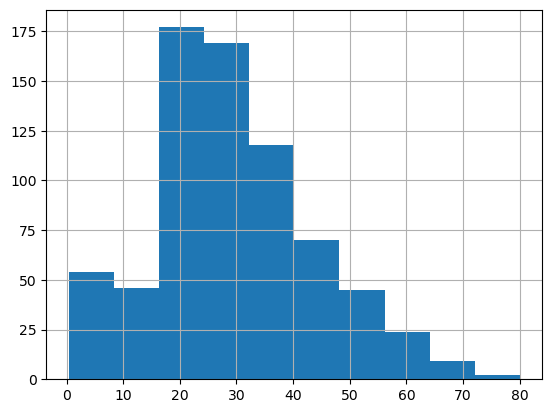

In [6]:
df['Age'].hist()

In [7]:
# Predicting missing value on the 'Age' column with linear regression
from sklearn.linear_model import LinearRegression

age_df = df[['Survived', 'Pclass', 'Age', 'Fare']]
known_age = age_df.loc[age_df['Age'].notna()] # Dataframe with 4 features above where no Age is missing
unknown_age = age_df.loc[age_df['Age'].isna()] # Like above but with all the age missing

model = LinearRegression()
model.fit(known_age.drop('Age', axis=1), known_age['Age'])
predicted_age = model.predict(unknown_age.drop('Age', axis=1))

# Fill in the missing age value with predicted values
df.loc[df['Age'].isna(), 'Age'] = predicted_age

<Axes: >

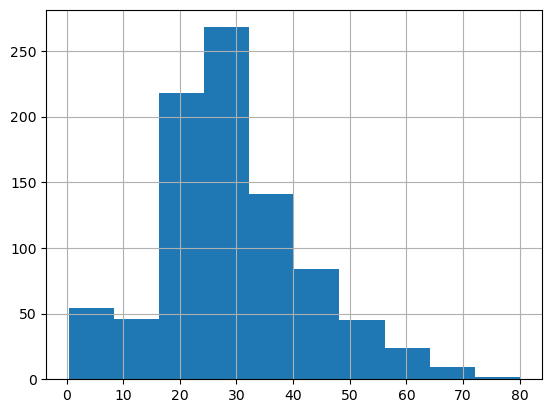

In [8]:
df['Age'].hist()

In [9]:
df['Age'].isnull().sum()

0

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [10]:
X = df[['Pclass', 'Parch']]
y = df['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [11]:
# ANSWER
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [13]:
# ANSWER
# Create Model
model = LogisticRegression(max_iter=1000)

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [14]:
# ANSWER
# Fit Model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [15]:
# ANSWER
model.coef_[0]

array([-0.87239066,  0.337888  ])

The computed intercept (`intercept_`) is the 1st element of another array:

In [16]:
# ANSWER
model.intercept_[0]

1.3043028200166613

We can create tuples of the predictor names and coefficients like this:

In [17]:
# ANSWER
feature_cols = X.columns
print(set(zip(feature_cols, model.coef_[0])))

{('Parch', 0.3378880048779747), ('Pclass', -0.8723906606017789)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [18]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872391
Parch       +0.337888


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [19]:
# ANSWER
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

What is the  `accuracy_score` for the test data?

In [20]:
# ANSWER
print(accuracy)

0.6901197604790419


What can we say about this result?

ANSWER
- The accuracy indicates that around 2/3 of the time we will be correct
- It's not that high

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [21]:
# ANSWER
# Have done this via linear regression instead to fill in the missing value. So just adding to it
X = X.copy()
X['Age'] = df['Age']
X

,Pclass,Parch,Age
PassengerId,,,
1,3,0,22.000000
2,1,0,38.000000
3,3,0,26.000000
4,1,0,35.000000
5,3,0,35.000000
...,...,...,...
887,2,0,27.000000
888,1,0,19.000000
889,3,2,25.919128


In [22]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
ModelWithAge = LogisticRegression(max_iter=1000)

# Fit Model
ModelWithAge.fit(X_train, y_train)

# Score
y_pred = ModelWithAge.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(accuracy)

0.7095808383233533


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Maybe age doesn't have strong correlation to survivalship
- Maybe the way we fill the missing value on the age column isn't too accurate
- Maybe age has too high of collinearity with Pclass and Parch

Let's see where the model is going wrong by showing the Confusion Matrix:

In [23]:
# ANSWER
y_pred_class = ModelWithAge.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[99 29]
 [50 45]]


Nb. Here is how `confusion_matrix` arranges its output:

In [24]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: False negative has 50 counts there. If error means how many times it doesn't predict things correctly, the False negative of 50 is more prevalent that the 29 False positive

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

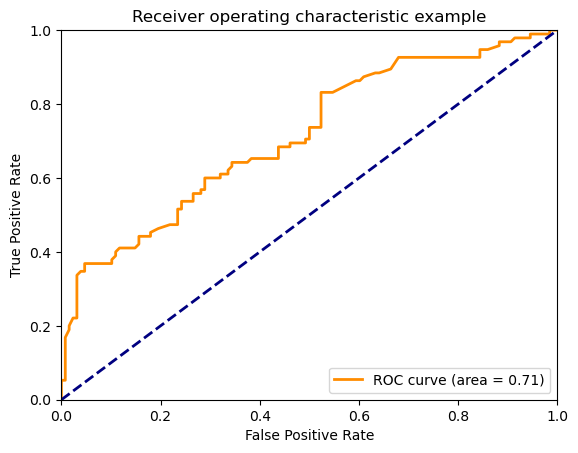

In [35]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = ModelWithAge.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [54]:
print(y_test.iloc[1:10])
print(preds[1:10])

PassengerId
224    0
85     1
681    0
536    1
624    0
149    0
4      1
35     0
242    1
Name: Survived, dtype: int64
[0.19743408 0.57979296 0.19750371 0.78002862 0.24405651 0.45144273
 0.66487511 0.73724479 0.25902508]


### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [217]:
titanic_with_dummies = pd.get_dummies(data = df, columns = ['Sex', 'Embarked', 'Pclass'],
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [218]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [219]:
# ANSWER
# Set Feature Both Numerical, Categorical
X = titanic_with_dummies.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis=1)
X

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,
1,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
2,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0
3,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1
4,35.000000,1,0,53.1000,1,0,0,0,1,1,0,0
5,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
887,27.000000,0,0,13.0000,0,1,0,0,1,0,1,0
888,19.000000,0,0,30.0000,1,0,0,0,1,1,0,0
889,25.919128,1,2,23.4500,1,0,0,0,1,0,0,1


In [220]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
ModelWithDummy = LogisticRegression(max_iter=1000)
ModelWithDummy.fit(X_train, y_train)

y_pred = ModelWithDummy.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(accuracy)

0.8263473053892215


Plot the ROC curve for the new model:

In [1]:
# ANSWER
preds = ModelWithDummy.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

NameError: name 'ModelWithDummy' is not defined

Can we improve the model by including the remaining features?

In [222]:
# ANSWER
# I'm not sure what to do with this one as I've already done the model with all numerical and categorical data above
# The only columns I dropped was Name, Cabin, and Ticke t as those won't have any effect on the prediction at all

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [223]:
# I initially try to run the train_test_split manually over and over and it does get different result each time.
# Then, I thought why not create a loop and see what the result looks like over time

accuracy_list=[]

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ModelWithDummy = LogisticRegression(max_iter=1000)
    ModelWithDummy.fit(X_train, y_train)

    y_pred = ModelWithDummy.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    
    accuracy_list.append(accuracy)

In [224]:
accuracy_df = pd.DataFrame({'Accuracy': accuracy_list})

Accuracy    0.816265
dtype: float64


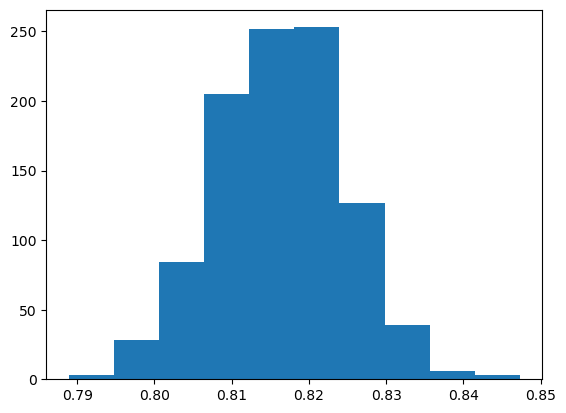

In [225]:
print(accuracy_df.mean())
plt.hist(accuracy_df);

In [226]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [227]:
# Trying what the accuracy score look like with cross validation. 
# The mean of accuracy of each fold is slightly lower than the original model 
scores = cross_val_score(ModelWithDummy, X_train, y_train)
print("Cross-validated scores:", scores)
print("Mean of Cross-validated scores:", scores.mean())

Cross-validated scores: [0.79850746 0.85074627 0.74626866 0.85714286 0.79699248]
Mean of Cross-validated scores: 0.8099315452811131


In [66]:
# ROC_curve as I understand it is about seeing what the result will be like when tweaking the logreg threshold
# Usually it's anything 0.5 or higher is a 1, and anything else is 0
# We'll now do cross validation with model with predict_proba as the method
# I use entire dataset instead of X_train, and y_train because cross validation is like a rotating train test split
# It won't make sense to do it with the split data

crossval_preds = cross_val_predict(model, X, y, cv=5, method='predict_proba')
crossval_preds

array([[0.77107518, 0.22892482],
       [0.33149665, 0.66850335],
       [0.80558678, 0.19441322],
       ...,
       [0.75548722, 0.24451278],
       [0.23341918, 0.76658082],
       [0.81979625, 0.18020375]])

In [67]:
# grab the positive values only and use it as argument for the roc_curve and then calculate the roc_auc for it
crossval_preds_pos = crossval_preds[:,1]
fpr, tpr, _ = metrics.roc_curve(y, crossval_preds_pos)
crossval_roc_auc = metrics.auc(fpr, tpr)
crossval_roc_auc

0.743230647961738

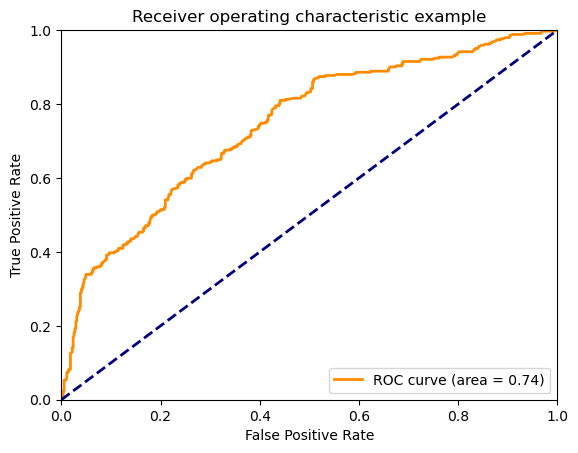

In [69]:
# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % crossval_roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



